Questions 1 & 2

In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm  # Optional: for progress bars

# Configuration
BASE_PATH = 'archive'
IMGSIZE = (128, 128)
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Initialize lists
X_tr, y_tr, X_ts, y_ts = [], [], [], []

# Load Training Data
print("Loading training data...")
for label in CNAMES:
    path = os.path.join(BASE_PATH, 'seg_train', 'seg_train', label)
    image_files = sorted([f for f in os.listdir(path) if f.lower().endswith('.jpg')])
    
    for f in tqdm(image_files, desc=f'Training - {label}'):
        img = cv2.imread(os.path.join(path, f))
        img = cv2.resize(img, IMGSIZE)
        X_tr.append(img)
        y_tr.append(CNAMES.index(label))

# Load Testing Data
print("\nLoading testing data...")
for label in CNAMES:
    path = os.path.join(BASE_PATH, 'seg_test', 'seg_test', label)
    image_files = sorted([f for f in os.listdir(path) if f.lower().endswith('.jpg')])
    
    for f in tqdm(image_files, desc=f'Testing - {label}'):
        img = cv2.imread(os.path.join(path, f))
        img = cv2.resize(img, IMGSIZE)
        X_ts.append(img)
        y_ts.append(CNAMES.index(label))

# Convert to numpy arrays
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)
X_ts = np.array(X_ts)
y_ts = np.array(y_ts)

# Normalize pixel values to [0, 1]
X_tr = X_tr.astype('float32') / 255.0
X_ts = X_ts.astype('float32') / 255.0

# Display dataset information
print("\n" + "="*50)
print("Datasraining set shape: {X_tr.shape}")
print(f"Training labels shape: {y_tr.shape}")
print(f"Testing set shape: {X_ts.shape}")
print(f"Testet loaded successfully!")
print("="*50)
print(f"Ting labels shape: {y_ts.shape}")
print(f"\nClass distribution in training set:")
for i, label in enumerate(CNAMES):
    count = np.sum(y_tr == i)
    print(f"  {label}: {count}")

Loading training data...


Training - street: 100%|██████████| 2382/2382 [00:00<00:00, 5081.22it/s]



Loading testing data...


Testing - street: 100%|██████████| 501/501 [00:00<00:00, 5095.09it/s]



Datasraining set shape: {X_tr.shape}
Training labels shape: (14034,)
Testing set shape: (3000, 128, 128, 3)
Testet loaded successfully!
Ting labels shape: (3000,)

Class distribution in training set:
  buildings: 2191
  forest: 2271
  glacier: 2404
  mountain: 2512
  sea: 2274
  street: 2382


Image array shape: (14034, 128, 128, 3)
Number of samples: 14034
Image dimensions: 128 x 128
Number of color channels: 3



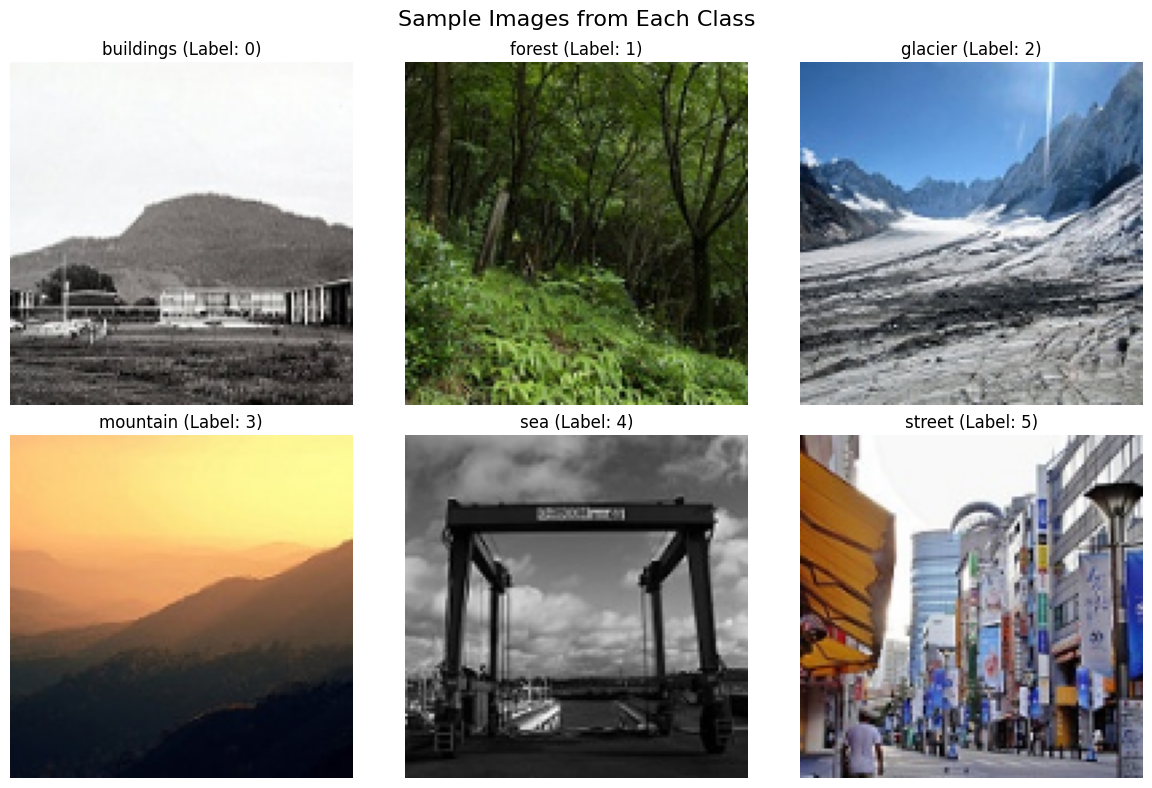

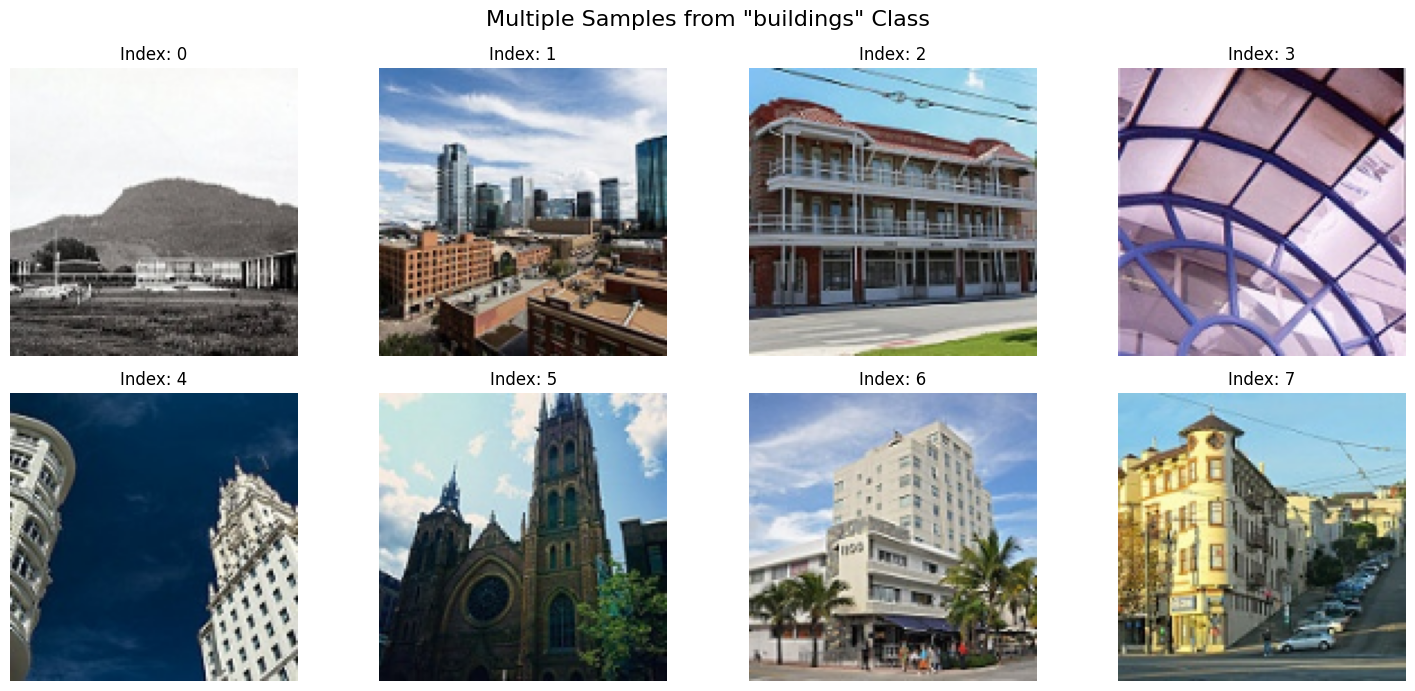

In [2]:
import matplotlib.pyplot as plt

# Check the shape and number of channels
print("Image array shape:", X_tr.shape)
print("Number of samples:", X_tr.shape[0])
print("Image dimensions:", X_tr.shape[1], "x", X_tr.shape[2])
print("Number of color channels:", X_tr.shape[3])
print()

# Display sample images from each class
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, (ax, class_name) in enumerate(zip(axes.flat, CNAMES)):
    # Find first image of this class
    idx = np.where(y_tr == i)[0][0]
    
    # Convert BGR to RGB for proper display
    img_rgb = cv2.cvtColor(X_tr[idx], cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_rgb)
    ax.set_title(f'{class_name} (Label: {i})')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display multiple samples from one class
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
fig.suptitle('Multiple Samples from "buildings" Class', fontsize=16)

buildings_indices = np.where(y_tr == 0)[0][:8]  # Get first 8 building images

for ax, idx in zip(axes.flat, buildings_indices):
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(X_tr[idx], cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_rgb)
    ax.set_title(f'Index: {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

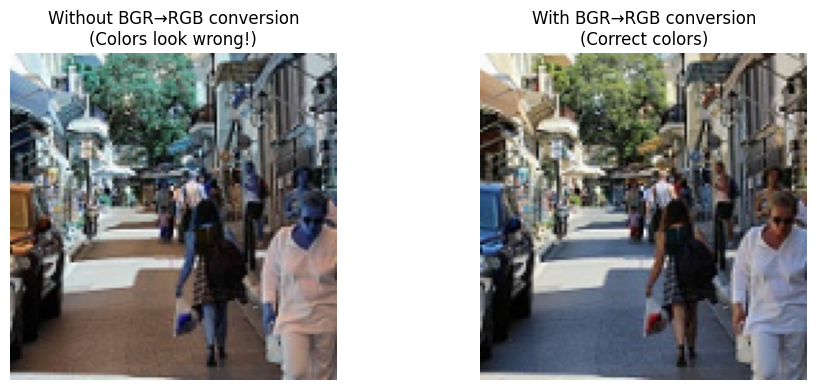

Class: street


In [3]:
# Show the difference between BGR and RGB display
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sample_idx = 12000

# Display without conversion (BGR - will look wrong)
axes[0].imshow(X_tr[sample_idx])
axes[0].set_title('Without BGR→RGB conversion\n(Colors look wrong!)')
axes[0].axis('off')

# Display with conversion (RGB - correct colors)
img_rgb = cv2.cvtColor(X_tr[sample_idx], cv2.COLOR_BGR2RGB)
axes[1].imshow(img_rgb)
axes[1].set_title('With BGR→RGB conversion\n(Correct colors)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Class: {CNAMES[y_tr[sample_idx]]}")

There are 3 color channels: Blue, Green, & Red (BGR). Note: When plotting using Matplotlib the channel order must be reversed to display the image in correct color.

Question 3:
Trying to match your results with the same network architecture, I initially did not use regularization, shown in the first following cell, which resulted in a high training accuracy, 93%, and low test accuracy, 54% compared to the 60% and 55%, respectively, mentioned in the question prompt. Indicating overfitting and poor generalization. In the subsequent cell, I added weight decay to the optimizer and that yielded the results that are closer to expected without hyperparameter tunning. 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Set device to CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Convert numpy arrays to PyTorch tensors
X_tr_tensor = torch.FloatTensor(X_tr)
y_tr_tensor = torch.LongTensor(y_tr)
X_ts_tensor = torch.FloatTensor(X_ts)
y_ts_tensor = torch.LongTensor(y_ts)

print(f"Training data shape: {X_tr_tensor.shape}")
print(f"Testing data shape: {X_ts_tensor.shape}")

# Create DataLoader for batch processing
batch_size = 64
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_ts_tensor, y_ts_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class ImageClassifier(nn.Module):
    def __init__(self, input_size=128*128*3, hidden_size=50, num_classes=6):
        super(ImageClassifier, self).__init__()
        
        # 3 hidden layers with 50 nodes each
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Flatten the 3D image to 1D vector
        x = torch.flatten(x, start_dim=1)
        
        # Forward pass through layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on output layer (handled by loss function)
        
        return x

# Initialize model, loss function, and optimizer
model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
num_epochs = 200
train_losses = []
train_accs = []
test_accs = []

print("\n" + "="*70)
print("Starting Training...")
print("="*70)

start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate on test set every 10 epochs
    if (epoch + 1) % 10 == 0:
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

end_time = time.time()
training_time = end_time - start_time

print("="*70)
print(f"Training completed in {training_time/60:.2f} minutes")
print("="*70)

# Final evaluation on training set
print("\nFinal Training Set Performance:")
train_loss, train_acc, train_preds, train_labels = evaluate(model, train_loader, criterion, device)
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Final evaluation on test set
print("\nFinal Testing Set Performance:")
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Testing Accuracy: {test_acc:.2f}%")
print(f"Testing Loss: {test_loss:.4f}")

# Detailed classification report
print("\n" + "="*70)
print("Classification Report on Test Set:")
print("="*70)
print(classification_report(test_labels, test_preds, target_names=CNAMES, digits=4))

# Confusion Matrix
print("\nConfusion Matrix on Test Set:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)
print("\nClass names:", CNAMES)

Using device: cpu
Training data shape: torch.Size([14034, 128, 128, 3])
Testing data shape: torch.Size([3000, 128, 128, 3])

Model Architecture:
ImageClassifier(
  (fc1): Linear(in_features=49152, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=6, bias=True)
  (relu): ReLU()
)

Total parameters: 2463056

Starting Training...
Epoch [10/200] - Train Loss: 0.9883, Train Acc: 62.48% - Test Loss: 1.1267, Test Acc: 56.00%
Epoch [20/200] - Train Loss: 0.8902, Train Acc: 65.81% - Test Loss: 1.1931, Test Acc: 55.87%
Epoch [30/200] - Train Loss: 0.7538, Train Acc: 71.59% - Test Loss: 1.1974, Test Acc: 58.27%
Epoch [40/200] - Train Loss: 0.6700, Train Acc: 74.51% - Test Loss: 1.3867, Test Acc: 53.93%
Epoch [50/200] - Train Loss: 0.5904, Train Acc: 77.77% - Test Loss: 1.4135, Test Acc: 56.80%
Epoch [60/200] - Train Loss: 0.5419, Train Acc: 79.74% - Test L

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Set device to CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Convert numpy arrays to PyTorch tensors
X_tr_tensor = torch.FloatTensor(X_tr)
y_tr_tensor = torch.LongTensor(y_tr)
X_ts_tensor = torch.FloatTensor(X_ts)
y_ts_tensor = torch.LongTensor(y_ts)

print(f"Training data shape: {X_tr_tensor.shape}")
print(f"Testing data shape: {X_ts_tensor.shape}")

# Create DataLoader for batch processing
batch_size = 64
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_ts_tensor, y_ts_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class ImageClassifier(nn.Module):
    def __init__(self, input_size=128*128*3, hidden_size=50, num_classes=6):
        super(ImageClassifier, self).__init__()
        
        # 3 hidden layers with 50 nodes each
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the 3D image to 1D vector
        x = torch.flatten(x, start_dim=1)
        
        # Forward pass through layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))        
        x = self.fc4(x)  # No activation on output layer (handled by loss function)
        
        return x

# Initialize model, loss function, and optimizer
model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
num_epochs = 200
train_losses = []
train_accs = []
test_accs = []

print("\n" + "="*70)
print("Starting Training...")
print("="*70)

start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate on test set every 10 epochs
    if (epoch + 1) % 10 == 0:
        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

end_time = time.time()
training_time = end_time - start_time

print("="*70)
print(f"Training completed in {training_time/60:.2f} minutes")
print("="*70)

# Final evaluation on training set
print("\nFinal Training Set Performance:")
train_loss, train_acc, train_preds, train_labels = evaluate(model, train_loader, criterion, device)
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Final evaluation on test set
print("\nFinal Testing Set Performance:")
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Testing Accuracy: {test_acc:.2f}%")
print(f"Testing Loss: {test_loss:.4f}")

# Detailed classification report
print("\n" + "="*70)
print("Classification Report on Test Set:")
print("="*70)
print(classification_report(test_labels, test_preds, target_names=CNAMES, digits=4))

# Confusion Matrix
print("\nConfusion Matrix on Test Set:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)
print("\nClass names:", CNAMES)

Using device: cpu
Training data shape: torch.Size([14034, 128, 128, 3])
Testing data shape: torch.Size([3000, 128, 128, 3])

Model Architecture:
ImageClassifier(
  (fc1): Linear(in_features=49152, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=6, bias=True)
  (relu): ReLU()
)

Total parameters: 2463056

Starting Training...
Epoch [10/200] - Train Loss: 1.0601, Train Acc: 59.33% - Test Loss: 1.1578, Test Acc: 55.90%
Epoch [20/200] - Train Loss: 1.0022, Train Acc: 61.91% - Test Loss: 1.2947, Test Acc: 51.07%
Epoch [30/200] - Train Loss: 0.9638, Train Acc: 63.14% - Test Loss: 1.2236, Test Acc: 53.43%
Epoch [40/200] - Train Loss: 0.9304, Train Acc: 64.03% - Test Loss: 1.1441, Test Acc: 57.03%
Epoch [50/200] - Train Loss: 0.9571, Train Acc: 62.86% - Test Loss: 1.1626, Test Acc: 55.70%
Epoch [60/200] - Train Loss: 0.8945, Train Acc: 65.58% - Test L

Question 4:

Current Model Limitations

Ignores spatial structure - Flattening destroys the 2D relationships between pixels.
Too many parameters - 49,152 input features (128 pixels x 128 pixels x 3 color channels) → 50 nodes = 2.4M parameters just in first layer.
No translation invariance - A tree in the top-left vs bottom-right is treated as completely different.
No feature hierarchy - Can't learn edges → shapes → objects progression.

Proposed Improvement Strategy (Based on Raschka Ch. 14)

Convolutional Neural Networks

Rationale: CNNs preserve 2D spatial structure through convolution operations. 
Reference: Raschka et al., Chapter 14 - "Classifying Images with Deep CNNs".
Expected impact: Industry standard for image classification, 75-85% accuracy achievable.

Data Augmentation

Rationale: Artificially expand training set, improve generalization.
Reference: Raschka et al., Section on "Image transformation and data augmentation".
Expected impact: +5-10% accuracy improvement.

Advanced Regularization

Already applied: L2 regularization (weight decay) successfully.
To explore: Dropout in CNN context, Batch Normalization.
Reference: Raschka et al., Section on "Regularizing an NN with L2 regularization and dropout".